In [4]:
import re
import pandas as pd
import bs4
import requests
import spacy
#from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from spacy.matcher import Matcher 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm 

In [5]:
candidate_sentences = pd.read_csv("text.csv")
candidate_sentences.shape

(4419, 1)

In [6]:
candidate_sentences['sentence'][576]
#sentence sotune dataframe hast

'"aragorn arrives and slays lurtz, and watches boromir die peacefully."'

In [7]:
doc = nlp(candidate_sentences['sentence'][0])#mibare tu spacy

In [8]:
for i in doc.ents:
  print(i.text, "...>", i.label_)

In [9]:
for i in doc:
  print(i.text, "...>", i.dep_, "...>",i.lemma_, "...>",i.pos_, "...>",i.shape_, "...>",i.is_stop)
  print ("----"*20)
#dar graph danesh mohemtarin chiz edge o node hast

" ...> punct ...> " ...> PUNCT ...> " ...> False
--------------------------------------------------------------------------------
confused ...> advcl ...> confused ...> ADJ ...> xxxx ...> False
--------------------------------------------------------------------------------
and ...> cc ...> and ...> CCONJ ...> xxx ...> True
--------------------------------------------------------------------------------
frustrated ...> conj ...> frustrated ...> ADJ ...> xxxx ...> False
--------------------------------------------------------------------------------
, ...> punct ...> , ...> PUNCT ...> , ...> False
--------------------------------------------------------------------------------
connie ...> nsubj ...> connie ...> PROPN ...> xxxx ...> False
--------------------------------------------------------------------------------
decides ...> ROOT ...> decide ...> VERB ...> xxxx ...> False
--------------------------------------------------------------------------------
to ...> aux ...> to ...> PART 

In [10]:
def get_entities(sentence):
  sub = ""
  obj = ""

  prv_tok_dep = ""    
  prv_tok_text = ""   

  prefix = ""
  modifier = ""

  #in moshkele compound o modifier haro dorost mikone mesle football stadium ya nice shirt
  
  for tok in nlp(sentence):
    
    # dar jomle age ghesmate jadid punctuation ya hamun noghte ina nabud edame bde vagane boro bad
    if tok.dep_ != "punct":
    # compound yek loghat tanha nist mesle sunflower
      if tok.dep_ == "compound":
        prefix = tok.text
        # age kalame ghabli ham compound bud miad 2ta ro kenare ham mizare
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check mikone modifier hast ya na yani ghable esm ye sefat biyad mesle good house
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # age kalame ghabli baz comound bud biaresh ghable jadide
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        sub = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

    ## chunk 4
      if tok.dep_.find("obj") == True:
        obj = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [sub.strip(), obj.strip()]

In [11]:
get_entities(candidate_sentences['sentence'][1600])

['maipak', 'manipur']

In [12]:
#daryafte hame entity ha
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4419/4419 [01:07<00:00, 65.04it/s]


In [13]:
entity_pairs[:]

[['connie', 'own'],
 ['later  woman', '’s distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['m global', 'international sales rights'],
 ['musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'selene  gallio'],
 ['singer', 'sequel'],
 ['last  which', 'penn'],
 ['jessica chastain', 'same  character'],
 ['mauro fiore', ''],
 ['filming', 'october'],
 ['soundtrack', 'digitally  june'],
 ['album', 'digitally  august'],
 ['film', 'studios motion pictures'],
 ['it', '$  million'],
 ['', ''],
 ['it', 'executive producer yoshimitsu banno'],
 ['vivienne graham', 'former employee dr'],
 ['zero aw

In [12]:
def get_relation(sentence):
#ertebate beyne kalamat
  doc = nlp(sentence)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{"TEXT":'lemon'},["TEXT":'water']
              {'TEXT':'i.label_'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4419/4419 [00:47<00:00, 92.86it/s] 


In [14]:
pd.Series(relations).value_counts()[:50]

is               363
was              296
"                151
released on       87
are               74
include           73
were              63
released          39
composed by       35
's                34
have              31
became            30
has               29
released in       27
become            27
included          26
called            23
considered        22
produced          22
had               21
been              21
made              20
be                18
stars             18
used              18
scheduled         17
directed by       16
written by        15
received          14
hired             14
went              13
introduced in     13
produced by       13
set               13
wrote             13
sold              12
wanted            12
won               11
began in          11
began             11
includes          10
gave              10
cast as           10
features          10
going              9
shot in            9
directed           9
produced in  

In [15]:

source = [i[0] for i in entity_pairs]
#2 ta list sakhte

target = [i[1] for i in entity_pairs]
#dataframe bar asase dictionary dorost mikonim be name knowledge graph
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [16]:
kg_df

,source,target,edge
0,connie,own,decides
1,later woman,’s distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4414,confidencial,negatively film,responded
4415,le parisien,five star rating,gave
4416,museum collection,"37,000 film titles",includes
4417,predecessor,historical film 1946,was


In [17]:
# graph ro ba networkx misazim
G=nx.from_pandas_edgelist(df=kg_df,source= "source",target= "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

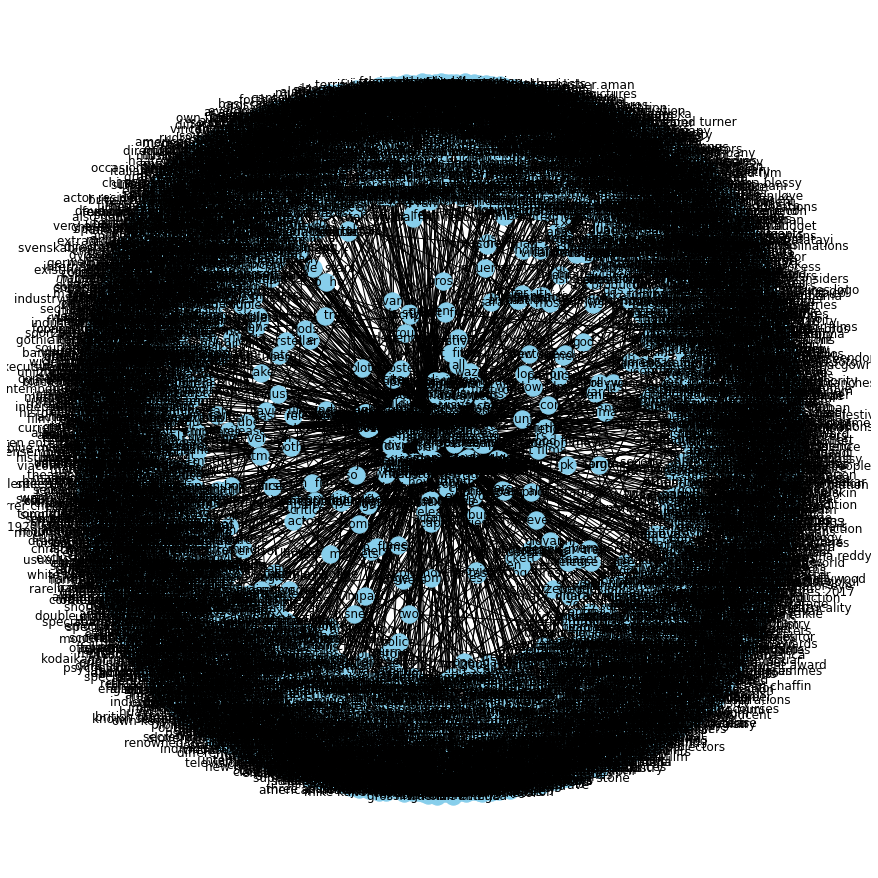

In [247]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

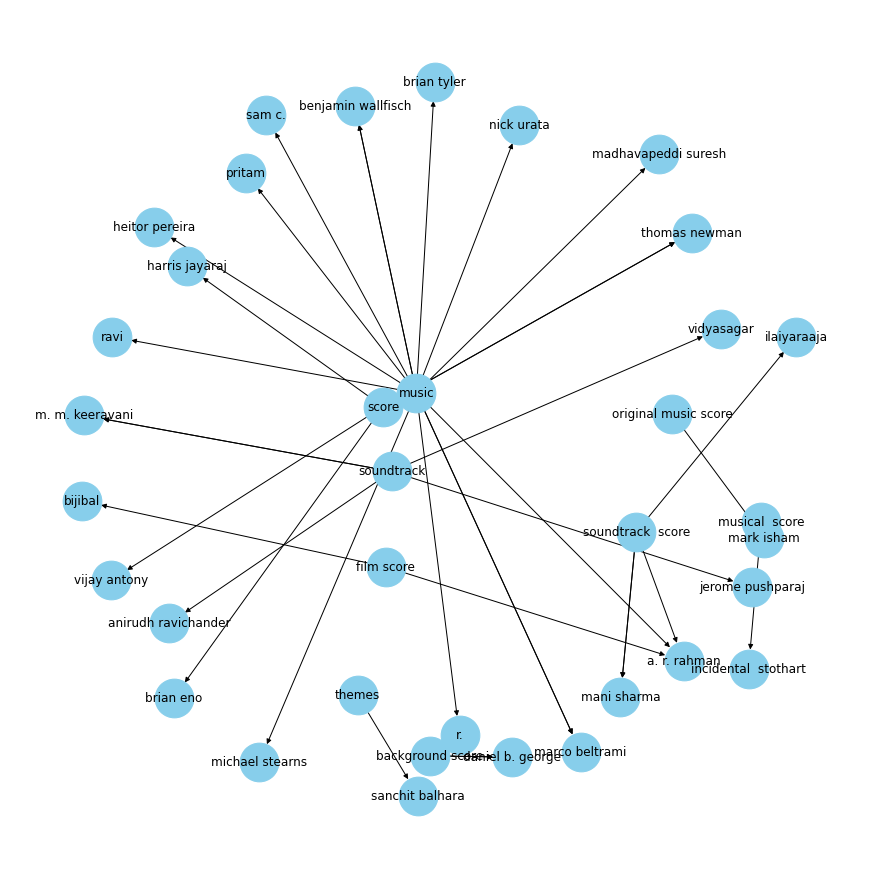

In [18]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [26]:
G.nodes

NodeView(('single', 'may', 'final  trailer', 'march', 'film', 'july', 'june', 'february', 'second studio album', 'sinister  november', 'album', 'educated  march', 'ii', 'august', 'hellbilly  deluxe', '2  february', 'april', 'internationally  film', '10,560  screens', 'second  trailer', 'theatrical  trailers', 'game', 'september', 'pk', '19  december', 'poster', '20  august', '15  september', 'full  soundtrack', '17  november', 'international  trailer', 'december', 'official  trailer', '10  november', 'trailer', '2  september', '3  may', 'movie', '9  november', 'two disc dvd edition', 'november', 'it', 'october', 'coraline', 'theatrically  february', 'soundtrack', 'spider homecoming', 'scooby doo', '21  october', '6  january', '17  december', 'dark  world', '2  june', 'ma', 'first  trailer', 'first  look', 'also directors cut', 'youtube', '2  dvd', 'three  sequels', 'forever batman june', 'batman', 'ultra hd', '19  january', '7  september', 'second  song', '21  august', 'malayalam versi

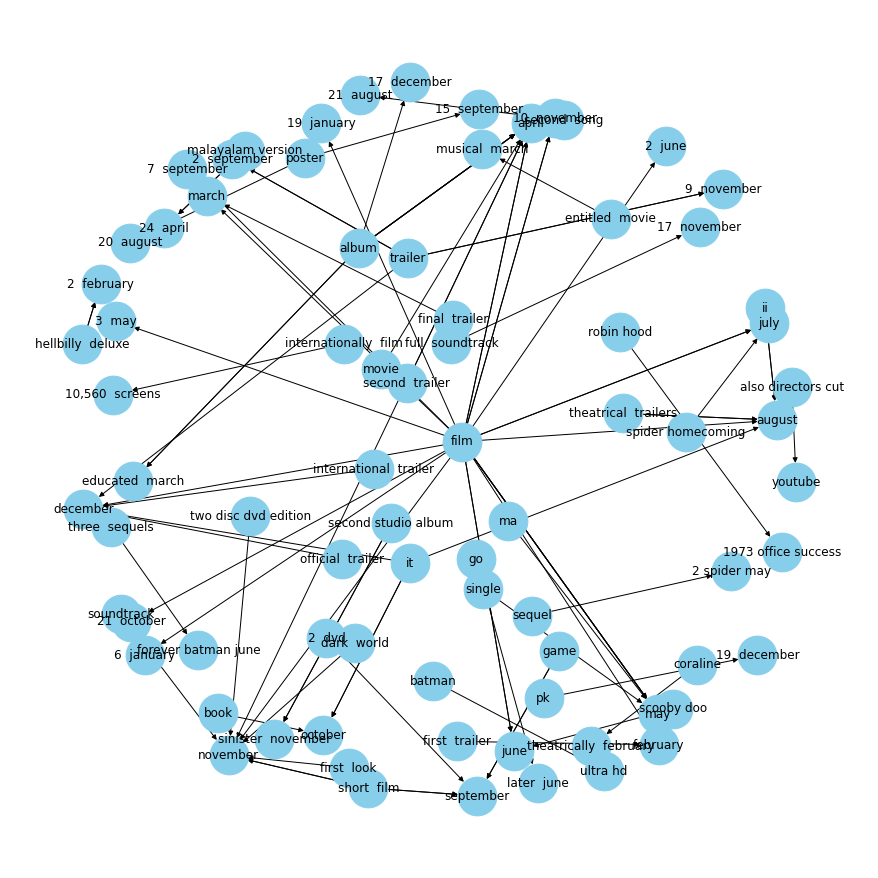

In [25]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=='released on'], "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()